# Sentiment Analysis - Logistic Regression 

In [4]:
#import libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 

In [5]:
#load data

df = pd.read_csv(r'C:\Users\Diego\Documents\ENGR - 195E\trainingandtestdata\training.1600000.processed.noemoticon.csv', header = None, encoding = "ISO-8859-1")
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text'] #set column names
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


it adds two columns to the dataframe, "words", is the tweet tokenized and the "@tag" s removed. num_words is the number of words that the tokenizer identified.

In [16]:
!pip install regex

In [17]:
import nltk
import regex

#new columned with clean text
df["words"] = [[word for word in nltk.casual.casual_tokenize(row.text) if not regex.match('@', word)] for _, row in df.iterrows()]
df["num_words"] = [len(row.words) for _, row in df.iterrows()]

In [19]:
df.head()

,target,id,date,flag,user,text,words,num_words
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[http://twitpic.com/2y1zl, -, Awww, ,, that's,...",21
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can't, update, his, Face...",24
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,"[I, dived, many, times, for, the, ball, ., Man...",19
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...",10
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","[no, ,, it's, not, behaving, at, all, ., i'm, ...",25


In [25]:
type(df.words[1])

list

In [26]:
type(df.text[1])

str

In [31]:
df.words = df.words.astype(str)

In [35]:
type(df.words[1])

str

In [57]:
type(df.words[2])

str

In [56]:
type(df.words[1:100])

pandas.core.series.Series

In [34]:
#df.head()

In [36]:
#split testing and training sets

train = df.sample(frac=.8)
test = df.drop(train.index)
print(len(train), len(test))

1280000 320000


In [38]:
#get closer look at the data set 

#training data
from sklearn.datasets import load_files
twitter_train = train
text_train, y_train = twitter_train.words, twitter_train.target
print("Number of documents in train data: {}".format(len(text_train)))
print("Samples per class (train): {}".format(np.bincount(y_train))) #4 bins, but only 0 and 4 have data

#testing data
twitter_test = test
text_test, y_test = twitter_test.words, twitter_test.target
print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test))) #4 bins, but only 0 and 4 have data

Number of documents in train data: 1280000
Samples per class (train): [639941      0      0      0 640059]
Number of documents in test data: 320000
Samples per class (test): [160059      0      0      0 159941]


# Count vectorizer 


Using CountVectorizer to convert text into tokens/features

In [39]:
#Bag Of Words; vectorizer

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=5, ngram_range=(2, 2))
X_train = vect.fit(text_train).transform(text_train) #vectorizer, sparse matrix of features 
X_test = vect.transform(text_test)

print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("X_train:\n{}".format(repr(X_train)))
print("X_test: \n{}".format(repr(X_test)))

Vocabulary size: 267000
X_train:
<1280000x267000 sparse matrix of type '<class 'numpy.int64'>'
	with 10255252 stored elements in Compressed Sparse Row format>
X_test: 
<320000x267000 sparse matrix of type '<class 'numpy.int64'>'
	with 2505662 stored elements in Compressed Sparse Row format>


In [67]:
type(vect)

sklearn.feature_extraction.text.CountVectorizer

In [62]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [40]:
#In total, it found 267000 features.

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 267000


In [63]:
type(feature_names)

list

In [66]:
feature_names[1:5]

['00 am', '00 and', '00 at', '00 but']

# Cross-Validation

Using GridSeachCV, we can find the best parameters for the Logistic Regression to minimize error. In this case, we use cv=5, meaning we did a 5-fold cross-validation. The best paraemters are shown below "Best estimator", which is the best model we can use to predict on the testing data.

In [51]:
#Model Development 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#determine what value of the parameter 'C' gives best performance/accuracy 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5) # original line of code
#grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.78
Best parameters:  {'C': 1}
Best estimator:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


# Predict

Using the "Best estimator", we achived a 78% accuracy rating in predicting the testing data. While not extremely accuarate, the accuracy rating is impressive for a Logistic Regression shollow learning algorithm on a data set this size.

In [52]:
#predict

lr = grid.best_estimator_
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

Score: 0.78


# Visualize top features in dataset

In [48]:
#!pip install mglearn

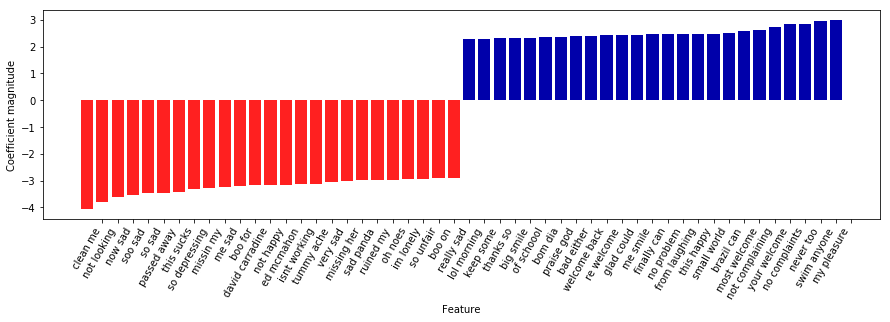

In [11]:
#top 25 neg/pos features in dataset 

import matplotlib.pyplot as plt
import mglearn

mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=25)
plt.show()

In [ ]:
from sklearn.svm import LinearSVC

#determine what value of the parameter 'C' gives best performance/accuracy 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_svm = GridSearchCV(LinearSVC(max_iter=1000), param_grid, cv=5) 
grid_svm.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid_svm.best_score_))
print("Best parameters: ", grid_svm.best_params_)
print("Best estimator: ", grid_svm.best_estimator_)

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
